In [30]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold,cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

In [31]:
df = pd.read_csv('../Base_Umbilo_Diaria.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

Q_entrada  NH_entrada  TSS_entrada  DQO_entrada  DBO_entrada  \
Dia                                                                   
0    4719.000000   21.000000   271.000000   391.000000   198.575000   
1    5866.458829   22.000327   276.000327   399.999347   203.059809   
2    5358.157069   23.998870   281.996233   406.995103   206.957307   
3    5266.313109   22.999791   278.000209   401.000418   203.710285   
4    6671.931586   21.000432   274.999568   396.999136   201.824410   
..           ...         ...          ...          ...          ...   
361  5587.915779   22.000000   182.001170   263.000000   134.093479   
362  5984.690649   22.998229   179.999646   259.000354   131.495253   
363  8328.225128   19.001002   177.000334   255.999332   129.609978   
364  5364.000000   18.000000   175.000000   251.000000   127.660000   
365  2334.275029   16.978515   172.957030   245.892574   125.668104   

     TN_entrada  TKN_entrada  TP_entrada  PO_entrada      Q_saida  NH_saida  \
Dia                                                                           
0     34.060000    34.060000    8.020000         4.6  6135.066621  3.854908   
1     35.360294    35.360294    8.099990         4.6  5636.285517  0.773286   
2     37.558734    37.558734    8.149966         4.6  5128.278103  0.572453   
3     36.399787    36.399787    8.109998         4.6  5036.211393  0.386242   
4     34.220441    34.220441    8.060004         4.6  6441.737326  0.376058   
..          ...          ...         ...         ...          ...       ...   
361   30.780012    30.780012    6.900000         4.6  5357.809665  0.229408   
362   31.668215    31.668215    6.869996         4.6  5754.451216  0.270272   
363   27.521002    27.521002    6.830000         4.6  8097.935230  0.336837   
364   26.370000    26.370000    6.790000         4.6  5134.741500  0.200074   
365   25.195292    25.195292    6.749141         4.6  2105.016529  0.100947   

      NO_saida  TSS_saida  DQO_saida  DBO_saida   TN_saida  TKN_saida  \
Dia                                                                     
0     0.079306   6.642565  83.782370   3.890641   5.042310   4.963005   
1     0.349220   5.766311  62.736147   2.720311   1.978541   1.629322   
2     0.692591   5.304955  55.605625   2.376578   2.021954   1.329363   
3     1.833623   4.898502  52.867768   2.081922   2.924917   1.091294   
4     4.070777   4.788757  51.670731   2.013649   5.128931   1.058154   
..         ...        ...        ...        ...        ...        ...   
361  20.738647   3.517159  35.116708   1.583500  21.428344   0.689698   
362  21.514507   3.509423  34.582476   1.606304  22.239991   0.725484   
363  19.448765   3.977019  34.977963   1.878834  20.261268   0.812503   
364  18.131642   3.398528  33.868320   1.663662  18.781715   0.650072   
365  19.066666   3.417396  33.183656   1.540150  19.608314   0.541648   

      TP_saida   PO_saida  
Dia                        
0     0.428499   0.326124  
1     9.226503   9.141557  
2    11.651663  11.575981  
3    12.464589  12.396924  
4    10.463329  10.398509  
..         ...        ...  
361   6.256764   6.209620  
362   5.447559   5.400288  
363   4.594725   4.540749  
364   4.667158   4.619641  
365   5.928673   5.881943  

[366 rows x 19 columns]

In [32]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Q_saida',
            'NH_saida',
            'NO_saida',
            'TSS_saida',
            'DBO_saida',
            'TN_saida',
            'TKN_saida',
            'TP_saida',
            'PO_saida',
            'DBO_entrada',
            'DQO_entrada',
            'TKN_entrada',
            'TP_entrada',
            'PO_entrada'], axis=1)

print("X", X.shape)
print("y", y.shape)

X (366, 4)
y (366,)


In [33]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (31, 4)
Test set y (31,)


In [34]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [35]:
# Epsilon-Support Vector Regression com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
          'degree': [x for x in range(2,5,1)],
          'tol': [1e-4],
          'C': [0.5,1,2,3,5],
          'epsilon': [0.01,0.05,0.1,0.5,1]
        } 
          # coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True

# criando o objeto do modelo com SVR
svr_model_cv_gs = SVR()

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(svr_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error')

# treinando o modelo com o grid search
grid_search.fit(normalized_x_train, normalized_y_train)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)



 Best hyperparameters:
{'C': 2, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly', 'tol': 0.0001}


In [36]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
svr_model_cv_gs.set_params(
                           degree = cv_best_params['degree']
                           )

# treinando um modelo com a melhor combinação de hiperparâmetros
svr_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = svr_model_cv_gs.get_params()

Average accuracy on train set: -1.027 +/- 0.109
Average accuracy on validation set: -1.121 +/- 0.387


In [38]:
# Realizando a predição no teste
y_test_pred_svr = svr_model_cv_gs.predict(normalized_x_test)

# Desnormalização
y_test_pred_svr = np.array(y_test_pred_svr).reshape(len(y_test_pred_svr),1)
y_test_pred_svr = scalery.inverse_transform(y_test_pred_svr)
y_test_pred_svr = pd.DataFrame(y_test_pred_svr, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_svr = y_test_pred_svr.squeeze()

y_test_pred_svr


# Análise dos erros das previsões
rmse_test_svr = math.sqrt(mean_squared_error(y_test, y_test_pred_svr))
mae_test_svr = mean_absolute_error(y_test, y_test_pred_svr)
mape_test_svr = mean_absolute_percentage_error(y_test, y_test_pred_svr)
r2_test_svr = r2_score(y_test, y_test_pred_svr)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_svr], 'MAE':[mae_test_svr], 'MAPE':[mape_test_svr],'R²':[r2_test_svr]})
df_metricas

RSME        MAE      MAPE        R²
0  15.440318  11.030999  0.227809  0.726606

In [39]:
# Cross-validation para averiguar precisão do modelo na base de treino
print('---------Treino---------')
results = cross_val_score(svr_model_cv_gs,X=X_training,y=y_training,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')
# Predição analisada por validação cruzada para o dataset inteiro
results_total = cross_val_score(svr_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------
[0.37513527 0.2659068  0.30445818 0.24286383 0.21792154 0.22553628
 0.24175802 0.19947955 0.24056868 0.27366563]
Média: 0.2587
Std: 0.048
---------Total---------
[0.36897019 0.23951911 0.29271985 0.29203747 0.16794635 0.24849335
 0.20345016 0.24362033 0.26595884 0.51034007]
Média: 0.2833
Std: 0.0915


In [40]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia

df_comparacao = pd.concat([y_test,y_test_pred_svr],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

Valor_Real  Valor_Predito  Diferenca_percentual
Dia                                                 
335   83.784619      74.507864            -11.072146
336   86.842041     101.259744             16.602215
337  119.987156     124.162408              3.479750
338  138.940253     115.317732            -17.001928
339  126.281606     106.315134            -15.811069
340  112.852382     113.379503              0.467089
341  113.403341     114.789141              1.222010
342   94.146869      72.397252            -23.101795
343   86.724664      98.906122             14.046128
344   80.682729      74.193725             -8.042619
345   81.205072      91.062918             12.139446
346   83.751125      86.716036              3.540145
347   82.638915      81.560007             -1.305569
348   80.704829      76.004761             -5.823776
349   75.640189      73.280180             -3.120047
350   69.679649      65.735678             -5.660148
351   67.571221      66.561722             -1.493976
352   68.423722      72.440316              5.870176
353   66.871361      67.028303              0.234693
354   62.369104      61.295328             -1.721648
355   57.040046      63.291835             10.960351
356   51.301994      50.913061             -0.758126
357   43.632757      47.321154              8.453277
358   38.710711      56.744382             46.585741
359   36.827353      58.511455             58.880424
360   35.834283      57.442573             60.300607
361   35.116708      54.799189             56.048764
362   34.582476      53.747339             55.417844
363   34.977963      50.474633             44.304095
364   33.868320      54.255897             60.196597
365   33.183656      83.803619            152.544863

        RSME        MAE      MAPE        R²
0  15.440318  11.030999  0.227809  0.726606


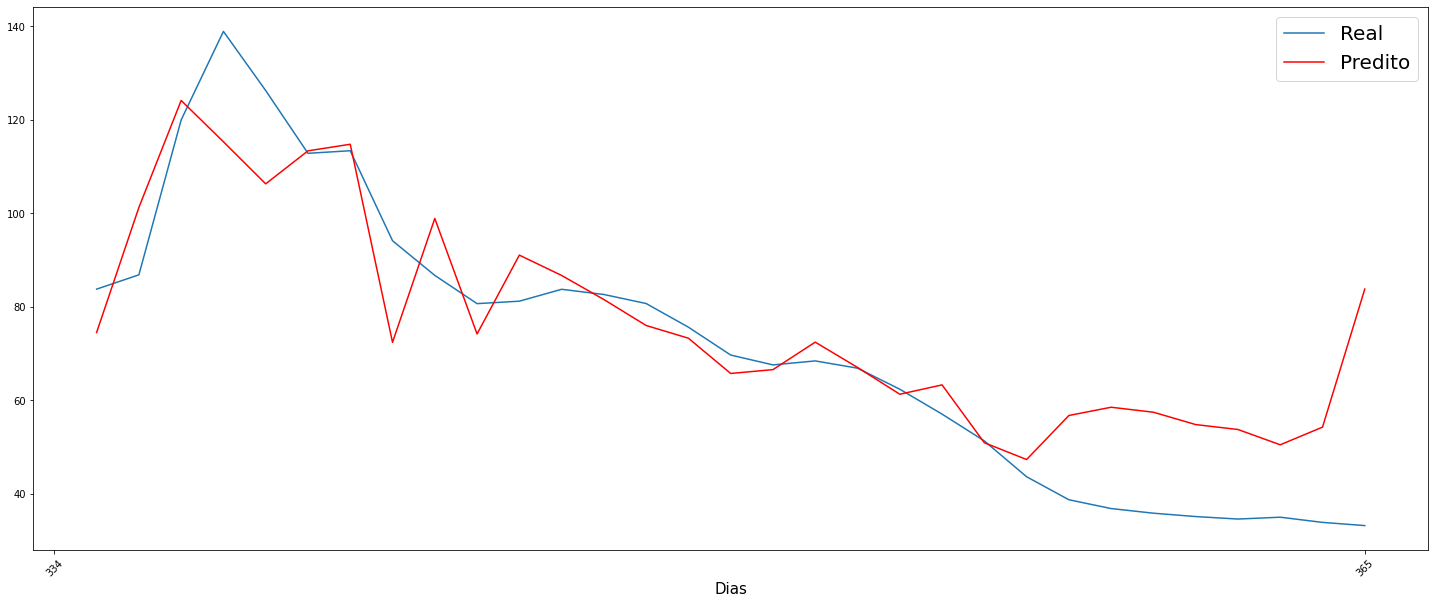

In [41]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [42]:
# Saving predictions

df_comparacao.to_csv("1_2-Previsoes_SVM.csv", encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME        MAE      MAPE        R²
0  24.283562  14.059709  0.122454  0.602976


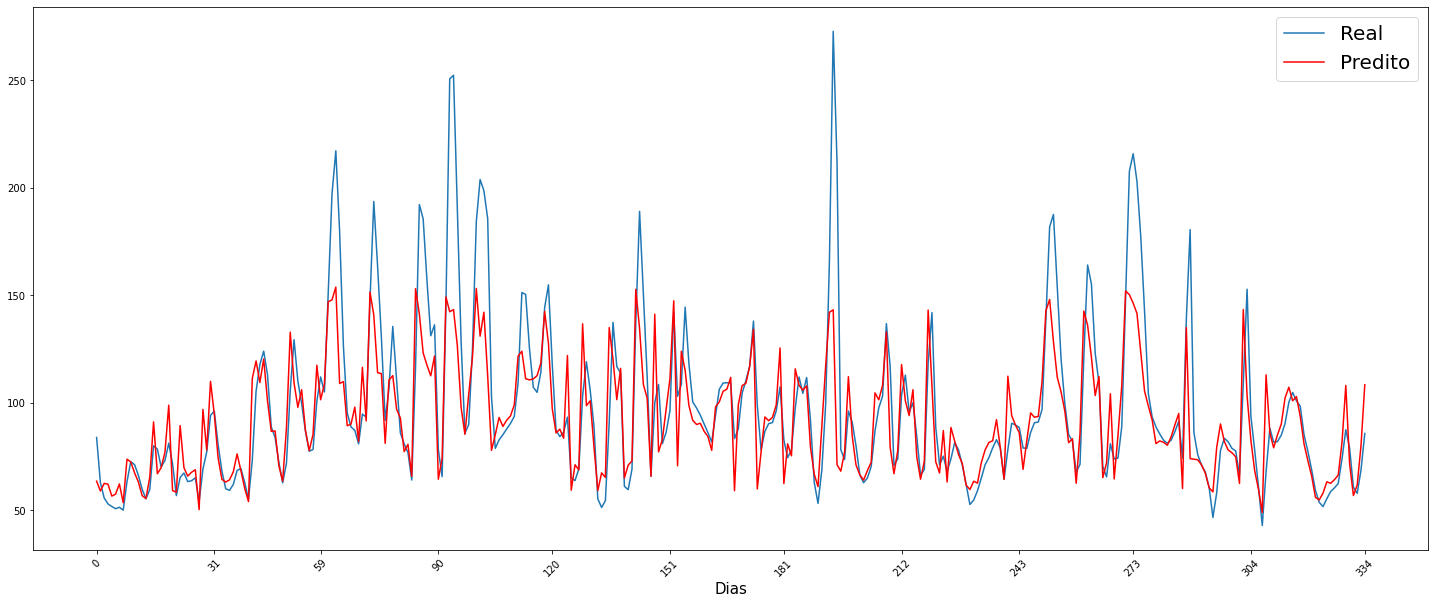

In [43]:
# Realizando a predição no traine
y_train_pred_rf = svr_model_cv_gs.predict(normalized_x_train)

# Desnormalização
y_train_pred_rf = np.array(y_train_pred_rf).reshape(len(y_train_pred_rf),1)
y_train_pred_rf = scalery.inverse_transform(y_train_pred_rf)
y_train_pred_rf = pd.DataFrame(y_train_pred_rf, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_rf = y_train_pred_rf.squeeze()

y_train_pred_rf


# Análise dos erros das previsões
rmse_train_rf = math.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_rf],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_rf], 'MAE':[mae_train_rf], 'MAPE':[mape_train_rf],'R²':[r2_train_rf]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [44]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_2-Previsoes_TREINO_SVM.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [45]:
print(normalized_x_train.min())
print(normalized_x_train.max())

Q_entrada     -2.727095
NH_entrada    -2.605314
TSS_entrada   -2.494750
TN_entrada    -2.588871
dtype: float64
Q_entrada      2.838441
NH_entrada     6.840331
TSS_entrada    4.629701
TN_entrada     4.368140
dtype: float64


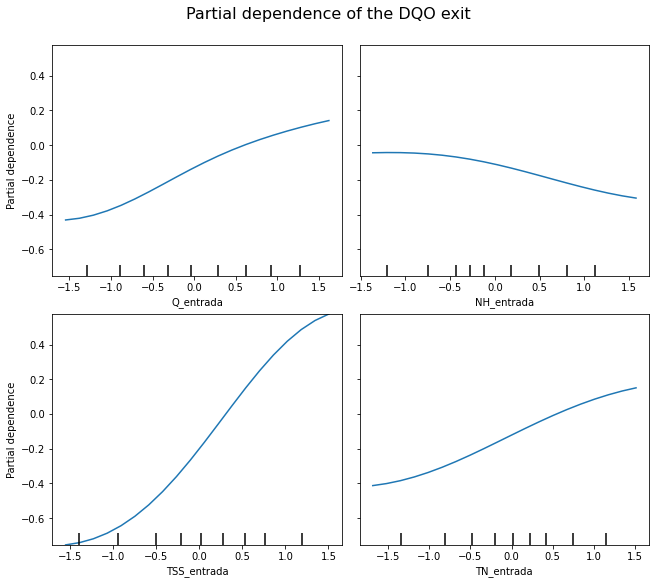

In [46]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    svr_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n",
    fontsize=16,
)

Importance_mean  Importance_std  Importance_mean_normalized
TSS_entrada         0.567201        0.059084                    0.556096
TN_entrada          0.182829        0.021089                    0.179249
Q_entrada           0.179730        0.028782                    0.176211
NH_entrada          0.090210        0.020969                    0.088443

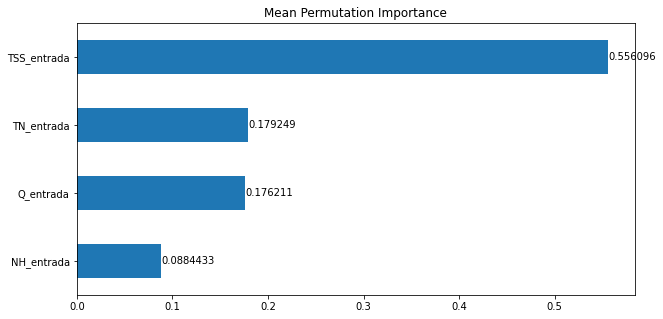

In [47]:
from sklearn.inspection import permutation_importance
r = permutation_importance(svr_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

ax = df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')
ax.bar_label(ax.containers[0])

df_permutation_importance

In [48]:
df_permutation_importance.to_csv('3_2-Permutation_Importance_SVM.csv',sep=';',decimal=',',encoding='utf-8-sig')

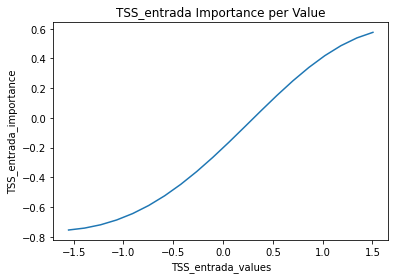

DBO_entrada_importance  Q_entrada_importance  Q_entrada_values  \
0                -0.430590             -0.430590         -1.545764   
1                -0.420732             -0.420732         -1.379149   
2                -0.403064             -0.403064         -1.212533   
3                -0.378001             -0.378001         -1.045917   
4                -0.346414             -0.346414         -0.879302   
5                -0.309557             -0.309557         -0.712686   
6                -0.268947             -0.268947         -0.546070   
7                -0.226214             -0.226214         -0.379454   
8                -0.182949             -0.182949         -0.212839   
9                -0.140557             -0.140557         -0.046223   
10               -0.100148             -0.100148          0.120393   
11               -0.062469             -0.062469          0.287008   
12               -0.027892             -0.027892          0.453624   
13                0.003547              0.003547          0.620240   
14                0.032065              0.032065          0.786855   
15                0.058019              0.058019          0.953471   
16                0.081787              0.081787          1.120087   
17                0.103655              0.103655          1.286702   
18                0.123734              0.123734          1.453318   
19                0.141919              0.141919          1.619934   

    NH_entrada_importance  NH_entrada_values  TSS_entrada_importance  \
0               -0.043594          -1.365209               -0.753843   
1               -0.042290          -1.210232               -0.740884   
2               -0.042746          -1.055255               -0.718675   
3               -0.045288          -0.900279               -0.686373   
4               -0.050184          -0.745302               -0.643285   
5               -0.057617          -0.590325               -0.588976   
6               -0.067672          -0.435349               -0.523379   
7               -0.080324          -0.280372               -0.446893   
8               -0.095431          -0.125395               -0.360455   
9               -0.112744           0.029582               -0.265570   
10              -0.131910           0.184558               -0.164298   
11              -0.152496           0.339535               -0.059179   
12              -0.174002           0.494512                0.046879   
13              -0.195886           0.649488                0.150770   
14              -0.217585           0.804465                0.249371   
15              -0.238534           0.959442                0.339742   
16              -0.258190           1.114418                0.419310   
17              -0.276043           1.269395                0.486027   
18              -0.291638           1.424372                0.538479   
19              -0.304585           1.579348                0.575953   

    TSS_entrada_values  
0            -1.551337  
1            -1.390468  
2            -1.229599  
3            -1.068730  
4            -0.907861  
5            -0.746992  
6            -0.586123  
7            -0.425254  
8            -0.264385  
9            -0.103516  
10            0.057353  
11            0.218222  
12            0.379091  
13            0.539960  
14            0.700828  
15            0.861697  
16            1.022566  
17            1.183435  
18            1.344304  
19            1.505173

In [49]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=[X.columns[0]+'_importance'])
for i in range(len(display.pd_results)):
    dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
    dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
    # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
    df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
    df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_2-PDPs_SVM.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp

In [50]:
# Avaliando na base de TESTE o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    svr_model_cv_gs, normalized_x_test, normalized_y_test, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}\n")

r2
    TSS_entrada: 0.621 +/- 0.128

    TN_entrada: 0.397 +/- 0.090

    NH_entrada: 0.159 +/- 0.038

neg_mean_absolute_percentage_error
    TSS_entrada: 0.428 +/- 0.117

    TN_entrada: 0.149 +/- 0.066

neg_mean_squared_error
    TSS_entrada: 0.364 +/- 0.075

    TN_entrada: 0.233 +/- 0.053

    NH_entrada: 0.093 +/- 0.022



In [51]:
# Avaliando na base de TREINO o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'] #, 'neg_mean_absolute_error'
r_multi = permutation_importance(
    svr_model_cv_gs, normalized_x_train, normalized_y_train, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}")

r2
    TSS_entrada: 0.567 +/- 0.059
    TN_entrada: 0.183 +/- 0.021
    Q_entrada: 0.180 +/- 0.029
    NH_entrada: 0.090 +/- 0.021
neg_mean_absolute_percentage_error
    TSS_entrada: 0.813 +/- 0.221
    Q_entrada: 0.671 +/- 0.283
neg_mean_squared_error
    TSS_entrada: 0.567 +/- 0.059
    TN_entrada: 0.183 +/- 0.021
    Q_entrada: 0.180 +/- 0.029
    NH_entrada: 0.090 +/- 0.021


## LIME - Local Interpretable Model-Agnostic Explanations 

In [52]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(normalized_x_train.values, feature_names=X.columns.values.tolist(),
                                                  class_names=[y.name], verbose=True, mode='regression')

### Cálculo da importância de cada variável para um registro específico

In [53]:
# normalized_x_test.iloc[5]
# normalized_x_test.values[5]

# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=4)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept -0.2645982529429559
Prediction_local [0.26445725]
Right: 0.4177469670916908


[('TSS_entrada > 0.67', 0.7136299496386221),
 ('TN_entrada > 0.54', 0.3305110098102475),
 ('Q_entrada <= -0.71', -0.3186089275196287),
 ('NH_entrada > 0.65', -0.19647653197086717)]

Interpretação: O valor Predito é o central da primeira imagem (Predicted value).
As variáveis à esquerda, tiveram influência negativa para o valor predito, enquanto que as variáveis à direita tiveram influência positiva.
Lista de Features com os respectivos valores alimentados para a previsão.

In [54]:
# Choose the 10th instance and use it to predict the results
j = 10
exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept -0.15340976109343357
Prediction_local [-0.05630717]
Right: -0.16131320631814924


[('0.02 < TSS_entrada <= 0.67', 0.20744046259461285),
 ('-0.71 < Q_entrada <= -0.04', -0.10472778278143437),
 ('-0.60 < TN_entrada <= 0.01', -0.07590945085830463),
 ('-0.59 < NH_entrada <= -0.12', 0.07029936633009891)]

In [55]:
# Choose the LAST instance and use it to predict the results
j = -1
exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept 0.12981261176127504
Prediction_local [-0.96456647]
Right: -0.349674044437965


[('TSS_entrada <= -0.68', -0.6281201918186023),
 ('TN_entrada <= -0.60', -0.29876565908671227),
 ('Q_entrada <= -0.71', -0.2916316740442492),
 ('NH_entrada <= -0.59', 0.12413844649892436)]

In [56]:
# Apply lime to last 20 observations
from interpret.blackbox import LimeTabular
from interpret import show


# Initilize Lime for Tabular data
lime = LimeTabular(model=svr_model_cv_gs, 
                   data=normalized_x_train, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(normalized_x_test, 
                                normalized_y_test, 
                                name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7001/3067920106016/ -->

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica

In [57]:
import warnings
warnings.filterwarnings("ignore")

import re
l=[]
for n in range(0,normalized_x_test.shape[0]):
     exp = explainer.explain_instance(normalized_x_test.values[n], svr_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_importances = df_lime_importances.append(row_values, ignore_index=True)

df_lime_importances

Intercept 0.003109800126803869
Prediction_local [-0.58282558]
Right: -0.5908759015571554
Intercept -0.19455993282422
Prediction_local [0.02753204]
Right: 0.10326919048914221
Intercept -0.36267770287692974
Prediction_local [0.54352479]
Right: 0.6975366699534419
Intercept -0.37441354436879637
Prediction_local [0.56641632]
Right: 0.4680391920303971
Intercept -0.2693776311921148
Prediction_local [0.26440824]
Right: 0.23444405022790907
Intercept -0.2864154184276906
Prediction_local [0.27523745]
Right: 0.4177469670916908
Intercept -0.25745038223092886
Prediction_local [0.22547431]
Right: 0.45432357895840536
Intercept -0.12014649285443511
Prediction_local [-0.20378993]
Right: -0.6456410558552159
Intercept -0.17564318678307986
Prediction_local [-0.02185673]
Right: 0.04219852040493924
Intercept -0.05199675193452004
Prediction_local [-0.34568752]
Right: -0.599027034756964
Intercept -0.1621202916719359
Prediction_local [-0.05011403]
Right: -0.16131320631814924
Intercept -0.1139875826019484
Predic

Q_entrada  TSS_entrada  TN_entrada  NH_entrada
0   -0.291684    -0.248481   -0.110462    0.064691
1   -0.068077     0.203568    0.301093   -0.214492
2   -0.101821     0.724328    0.311742   -0.028046
3   -0.093794     0.740574    0.305890   -0.011839
4   -0.325161     0.747395    0.316257   -0.204704
5   -0.307774     0.741106    0.321334   -0.193014
6   -0.312428     0.691810    0.312131   -0.208588
7    0.276503    -0.278025   -0.087597    0.005475
8   -0.106597     0.202868    0.075544   -0.018029
9    0.105048    -0.296143   -0.058715   -0.043881
10  -0.104767     0.195560   -0.060595    0.081807
11  -0.331292     0.197095    0.068582   -0.014782
12  -0.266669    -0.266666    0.059020   -0.192027
13  -0.085136    -0.264858    0.327836   -0.209791
14  -0.293607    -0.263269   -0.090814    0.071152
15  -0.083975    -0.636323   -0.303731    0.124621
16  -0.107685    -0.658045   -0.294570    0.151632
17  -0.285429    -0.279019   -0.068436    0.067159
18  -0.280356    -0.635563   -0.072280   -0.016228
19  -0.287956    -0.635228    0.075997   -0.205861
20  -0.071560    -0.656559    0.060846   -0.227007
21  -0.081958    -0.648620   -0.298041    0.101194
22  -0.304594    -0.647212   -0.315179    0.115289
23  -0.308952    -0.654457   -0.300481    0.135425
24  -0.291290    -0.632024   -0.285494    0.133897
25  -0.296862    -0.643928   -0.309525    0.126151
26  -0.297828    -0.635428   -0.273772    0.052577
27  -0.262283    -0.650263   -0.299635    0.058452
28   0.124992    -0.666584   -0.304440    0.138398
29  -0.305663    -0.639816   -0.287813    0.145701
30  -0.269270    -0.614034   -0.287081    0.118574

In [58]:
df_lime_absolute_importances = df_lime_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_absolute_importances.iloc[:,i] = df_lime_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_absolute_importances.head()

Q_entrada  TSS_entrada  TN_entrada  NH_entrada
0   0.291684     0.248481    0.110462    0.064691
1   0.068077     0.203568    0.301093    0.214492
2   0.101821     0.724328    0.311742    0.028046
3   0.093794     0.740574    0.305890    0.011839
4   0.325161     0.747395    0.316257    0.204704

In [59]:
df_lime_absolute_importances.mean()/df_lime_absolute_importances.mean().sum()

Q_entrada      0.204893
TSS_entrada    0.486887
TN_entrada     0.202273
NH_entrada     0.105947
dtype: float64

<Axes: >

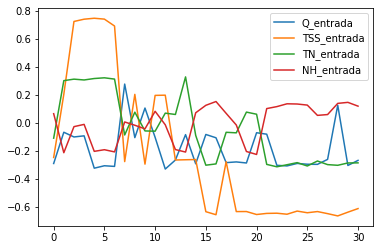

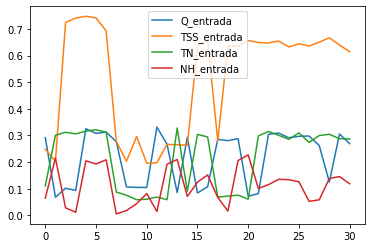

In [60]:
# df_lime_importances['TN'].plot()
df_lime_importances.plot()
df_lime_absolute_importances.plot()

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica para a BASE DE TREINO

In [61]:
l=[]
for n in range(0,normalized_x_train.shape[0]):
     exp = explainer.explain_instance(normalized_x_train.values[n], svr_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_train_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_train_importances = df_lime_train_importances.append(row_values, ignore_index=True)

df_lime_train_importances

Intercept 0.1389886706426043
Prediction_local [-1.00051954]
Right: -0.8780531036071327
Intercept 0.1503391111600081
Prediction_local [-1.01825397]
Right: -0.9966729264569452
Intercept 0.16616831530180828
Prediction_local [-1.00902346]
Right: -0.9044130665839344
Intercept 0.1552724557162557
Prediction_local [-1.01949737]
Right: -0.9141498873667198
Intercept 0.15865687343070792
Prediction_local [-1.00056574]
Right: -1.0578521983302804
Intercept 0.13106723803002543
Prediction_local [-0.96546559]
Right: -1.0344101793953
Intercept -0.0003262184516648614
Prediction_local [-0.56202884]
Right: -0.9105409537425396
Intercept 0.10858763670065189
Prediction_local [-0.84052773]
Right: -1.137681014893402
Intercept 0.05533129582197094
Prediction_local [-0.67383008]
Right: -0.6126570828009023
Intercept 0.055990231121191
Prediction_local [-0.67940307]
Right: -0.6451465047690692
Intercept 0.14117891094971377
Prediction_local [-0.98362317]
Right: -0.7781714763465792
Intercept 0.0873907707999314
Predictio

TSS_entrada  TN_entrada  Q_entrada  NH_entrada
0      -0.647854   -0.296372  -0.292171    0.096888
1      -0.654083   -0.301788  -0.293600    0.080879
2      -0.651416   -0.293532  -0.304729    0.074485
3      -0.652267   -0.304162  -0.283456    0.065115
4      -0.642560   -0.310535  -0.289972    0.083845
..           ...         ...        ...         ...
330    -0.279577   -0.105124   0.144026    0.080893
331    -0.661971   -0.310436  -0.078843    0.137745
332    -0.637482   -0.303165  -0.291117    0.126281
333    -0.271183   -0.074077  -0.282451    0.095239
334     0.757422    0.317191  -0.091888   -0.017576

[335 rows x 4 columns]

In [62]:
df_lime_train_absolute_importances = df_lime_train_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_train_absolute_importances.iloc[:,i] = df_lime_train_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_train_absolute_importances

TSS_entrada  TN_entrada  Q_entrada  NH_entrada
0       0.647854    0.296372   0.292171    0.096888
1       0.654083    0.301788   0.293600    0.080879
2       0.651416    0.293532   0.304729    0.074485
3       0.652267    0.304162   0.283456    0.065115
4       0.642560    0.310535   0.289972    0.083845
..           ...         ...        ...         ...
330     0.279577    0.105124   0.144026    0.080893
331     0.661971    0.310436   0.078843    0.137745
332     0.637482    0.303165   0.291117    0.126281
333     0.271183    0.074077   0.282451    0.095239
334     0.757422    0.317191   0.091888    0.017576

[335 rows x 4 columns]

In [63]:
df_lime_train_absolute_importances.mean()/df_lime_train_absolute_importances.mean().sum()

TSS_entrada    0.476082
TN_entrada     0.198567
Q_entrada      0.205275
NH_entrada     0.120077
dtype: float64

<Axes: >

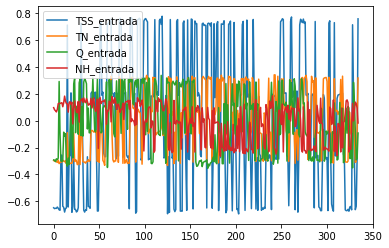

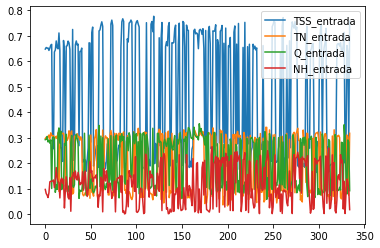

In [64]:
# df_lime_train_importances['TN'].plot()
df_lime_train_importances.plot()
df_lime_train_absolute_importances.plot()